In [1]:
location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)

# import statements
from brian2 import *
from funcs_pj import generate_new_color
import matplotlib.pyplot as plt
import numpy as np
from brian2_recurrentnet_seizures.brian2_utils import *
from brian2_recurrentnet_seizures.brian_recurrent_net_main import *

import pickle
import pandas as pd
import random


Welcome. This model is called ... rec_sz1


In [2]:
# create W matrix
inh_conn = 0.2
exc_conn = 0.2
E_prob = 0.80  # probability of excitatory cells (rest will be inhibitory)
Ntotal = 1000*5

# creating custom synaptic connectivity matrix for recurrent layer -- not quite a full synaptic weights matrix
Nn = Ntotal  # number of neurons in the recurrent layer
W = np.zeros([Nn, Nn])  # matrix of recurrent connection weights, should be a Nn x Nn size array
# W = np.diag(np.ones(Nn)) # -- self connections


###### spatially ordered connectivity
p_e = exc_conn  # probability of E->All connections
p_i = inh_conn  # probability of I->All connections neurons

Ne = random.sample(range(Nn), int(E_prob * Nn))
Ni = [x for x in range(Nn) if x not in Ne]

# need to intersperse E and I neurons throughout the whole cell population
for i in range(Nn):
    # select random indexes to setup as connections based on selected probability
    # set E --> all connectivity
    if i in Ne:
        j = [int(target) for target in np.random.normal(i, 200, int(p_e * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

    # set I --> all connectivity
    elif i in Ni:
        j = [int(target) for target in np.random.normal(i, 200, int(p_i * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

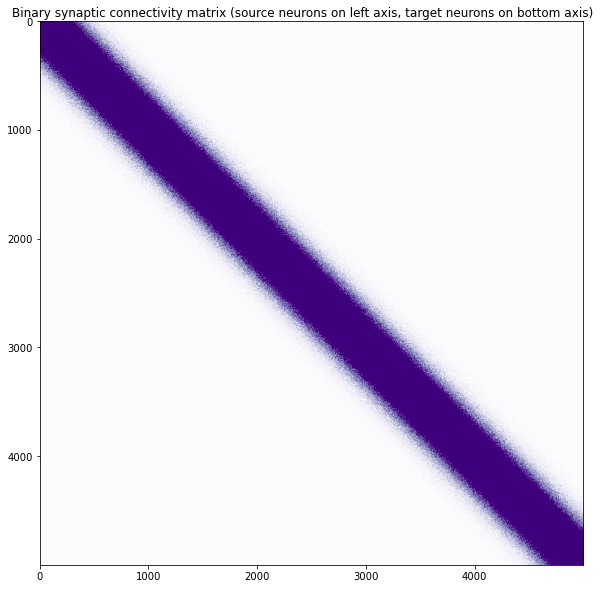

In [3]:
def plot_connectivity_matrix(conn_matrix, cmap='Purples', color_lim=[0.05, 0.1], colorbar=False):
    """plot heatmap of synaptic connectivity matrix given as numpy array where 1 denotes connection between i and j index"""
    # plt.figure(figsize=[10, 10])
    fig, ax = plt.subplots(figsize=(10, 10))

    ax = ax.imshow(conn_matrix, cmap=cmap, vmin=color_lim[0], vmax=color_lim[1])
#     plt.clim(color_lim[0], color_lim[1])
#     if title is not None:
#         ax.set_title(title)
    plt.suptitle('Binary synaptic connectivity matrix (source neurons on left axis, target neurons on bottom axis)', wrap=True, y = 0.90)
    if colorbar:
        plt.colorbar()
    plt.show()
    
plot_connectivity_matrix(W, color_lim=[0.0,0.51])









Time constants (in order of T_d_exc, T_d_inh, T_g):  5. ms 5. ms 250. ms


WARNING    "i" is an internal variable of group "neurongroup", but also exists in the run namespace with the value array([  0,   0,   0, ..., 999, 999, 999]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 3. s
2.9262 s (97%) simulated in 10s, estimated < 1s remaining.
3. s (100%) simulated in 10s


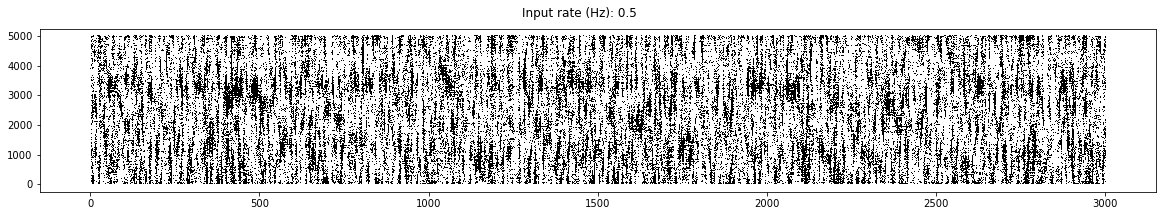

average spiking rate of population:  5.42 Hz


TypeError: make_spike_array() got an unexpected keyword argument 'runtime'

In [4]:
#%% BUILD AND RUN NETWORK

#### set some network parameters
runtime = 3*second
dt = 0.1*ms
neurons_to_stim = Ne[20:50]
stim_external = False
w_matrix = W


#### build and run simulation
spike_raster_binned_multi = None
for input_rate in [0.5]:
    for tau_di in [5, 8]:
        print('\n')
        print('\n')
        print('\n')
        print('\n')
        # build network
        record_id=[Ne[0], Ne[100], Ni[23], Ni[65]]
        net, W, trace, s_mon, trace_ge, s_mon_p, Ce, Ci, Ge, Gi, G, trace_z, trace_gi, trace_gi_diff = \
        build_network(Ntotal=Ntotal, record_id=record_id, runtime = runtime, inh_conn=inh_conn, input_rate=input_rate, stim_external = stim_external, neurons_to_stim = neurons_to_stim, Ne = Ne, Ni = Ni,
                      w_matrix = w_matrix, tau_di = tau_di)

        if stim_external:
            print('--- STIMULATION ACTIVE: %s neurons stimulated ----' % len(neurons_to_stim))

        # quick spike raster plot to initialize plotting
        plt.figure(figsize=[20,3])
        plt.plot(s_mon.t/ms, s_mon.i, ',k')
        plt.suptitle('Input rate (Hz): %s' % (input_rate))
    #     plt.suptitle(title)
        plt.show()
        spike_counts = s_mon.count
        spike_counts_Hz = array(spike_counts/runtime)
        avg=mean(spike_counts_Hz); print('average spiking rate of population: ', np.round(avg, 2), 'Hz')



        # make spike raster bins
        spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

        spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

        # create numpy array of spikes:
        binsize = 100 # ms
        spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), dt=dt, binsize=binsize)
        plot_firing_rate(spike_raster_binned, binsize_sec=0.01, title='Population Firing rate')
        ## plot histogram of firing rates for all neurons in network
        plot_firing_rate_histogram(spike_array=spike_array, len_sec = runtime / second)
        
        if spike_raster_binned_multi is None:
            spike_raster_binned_multi = spike_raster_binned
            print(spike_raster_binned_multi.shape)
        else:
            spike_raster_binned_multi = np.dstack((spike_raster_binned_multi, spike_raster_binned))
            print(spike_raster_binned_multi.shape)

        avg_corr = corr_coef(spike_raster_binned, binsize=binsize)


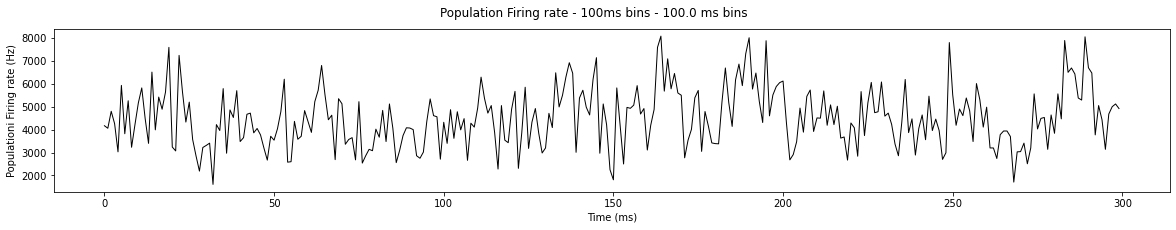

In [6]:
plot_firing_rate(spike_raster_binned_multi[:,:,0], binsize_sec=0.1, title='Population Firing rate - 100ms bins')



WARNING    <ipython-input-7-978a213e52ce>:27: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


0
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 2. 1. ... 0. 1. 2.]
 [0. 0. 0. ... 1. 2. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
LinregressResult(slope=-0.23815506172709486, intercept=6.126539895095849, rvalue=-0.9991397394419926, pvalue=1.190177049936927e-84, stderr=0.0012761288888033134, intercept_stderr=0.006150649176072641)


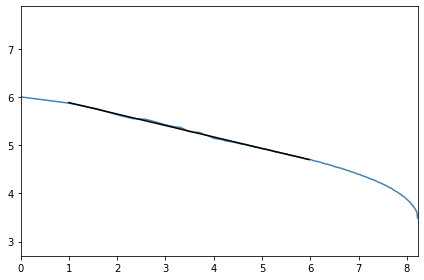

WARNING    <ipython-input-7-978a213e52ce>:27: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


1
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
LinregressResult(slope=-0.17805871742176108, intercept=5.244013994221809, rvalue=-0.996704864859381, pvalue=3.614558040972737e-67, stderr=0.0018707449903878233, intercept_stderr=0.00901656269576413)


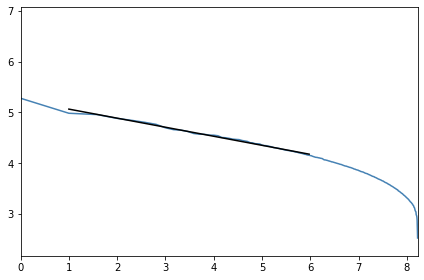

2


IndexError: index 2 is out of bounds for axis 2 with size 2

In [7]:
# PCA analysis
for i in range(3):
    print(i)
    spike_raster_binned = spike_raster_binned_multi[:,:,i]
    print(spike_raster_binned)
    pca = PCA(n_components=min(spike_raster_binned.shape))
    pca.fit(spike_raster_binned)
    pca_result = pd.DataFrame(pca.transform(spike_raster_binned))  # , columns=['PCA%i' % i for i in range(275)])
    sv = pca.singular_values_
    su = (sv / sum(sv))

    data = pca.explained_variance_ratio_
    data = sv

    subset = [2**1, 2**6]

    # fit and plot variance per PC

    x = range(len(data))[subset[0]:subset[1]]
    y = data[subset[0]:subset[1]]

    # to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
    res = stats.linregress(np.log2(x), np.log2(y))
    print(res)

    x_full = range(len(data))
    plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
    plt.plot(np.log2(x), res.intercept + res.slope * np.log2(x), c = 'black', label='fitted line')
    plt.ylim(min(res.intercept + res.slope * np.log2(x)) - 2, max(res.intercept + res.slope * np.log2(x)) + 2)
    plt.margins(x=0)
    plt.tight_layout()
    plt.show()


In [ ]:
G.equations

In [ ]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

# create numpy array of spikes:
spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=10)
plot_firing_rate(spike_raster_binned, binsize_sec=0.01, title='Population Firing rate - 10ms bins')

spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=100)
plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 100ms bins')



In [ ]:
# PCA and powerlaw fit of the eigen decomposition


pca = PCA(n_components=min(spike_raster_binned.shape))
pca.fit(spike_raster_binned)
pca_result = pd.DataFrame(pca.transform(spike_raster_binned))  # , columns=['PCA%i' % i for i in range(275)])
sv = pca.singular_values_
su = (sv / sum(sv))

data = pca.explained_variance_ratio_
data = sv

subset = [2**2,2**9]

# fit and plot variance per PC

x = range(len(data))[subset[0]:subset[1]]
y = data[subset[0]:subset[1]]

# to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
res = stats.linregress(np.log2(x), np.log2(y))
print(res)

x_full = range(len(data))
plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
plt.plot(np.log2(x), res.intercept + res.slope * np.log2(x), c = 'black', label='fitted line')
plt.ylim(-5, 5)
plt.margins(x=0)
plt.tight_layout()
plt.show()



### VARIOUS PLOTS FOR INHIBITORY EXHAUST MECH.

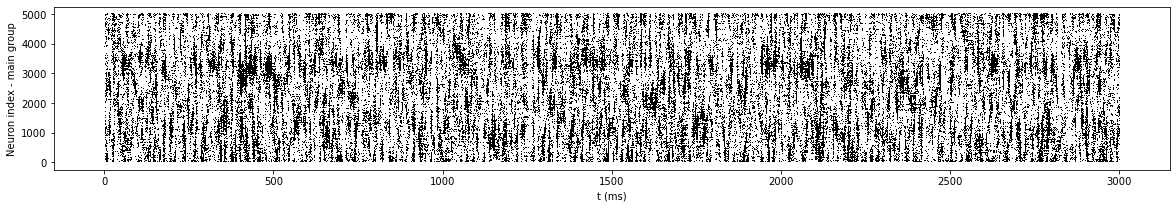

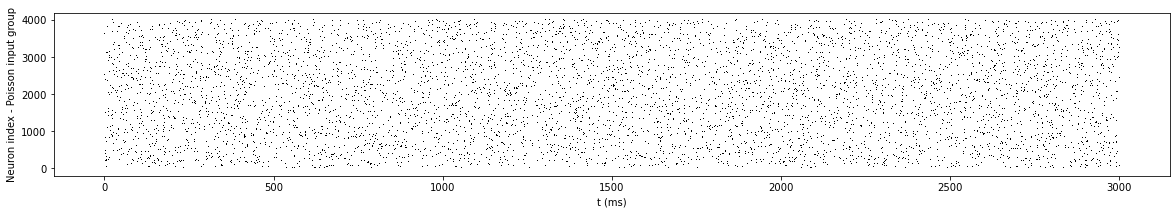

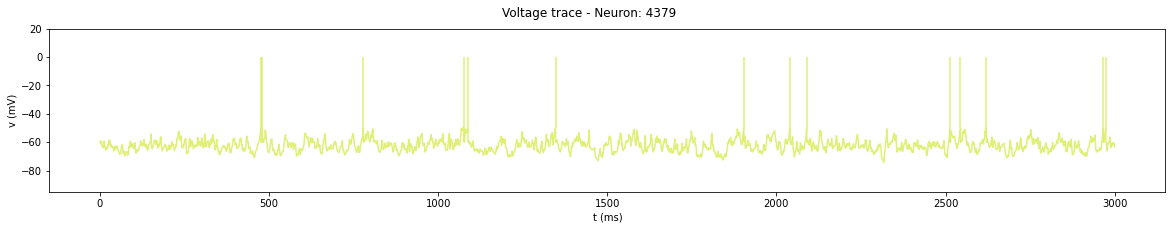

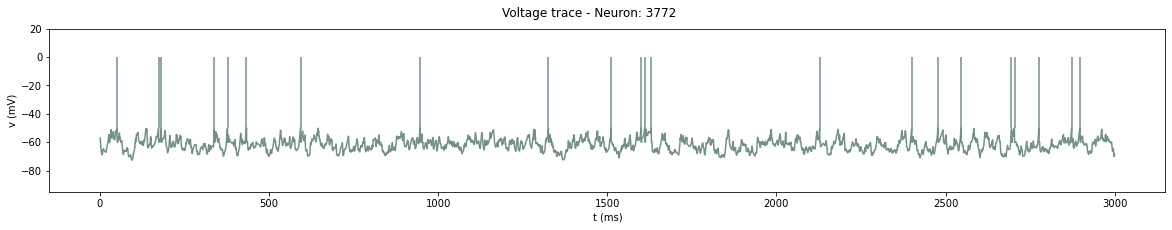

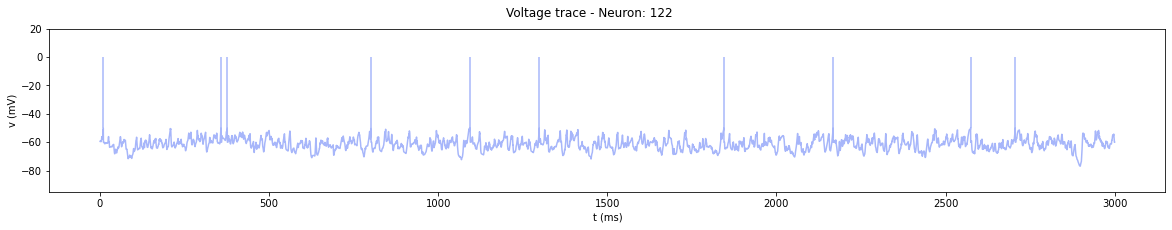

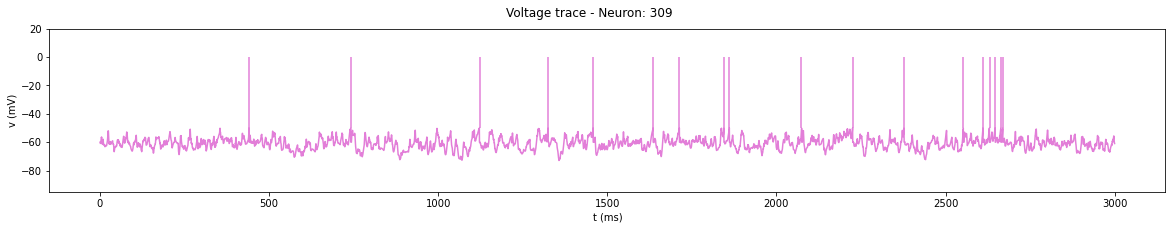

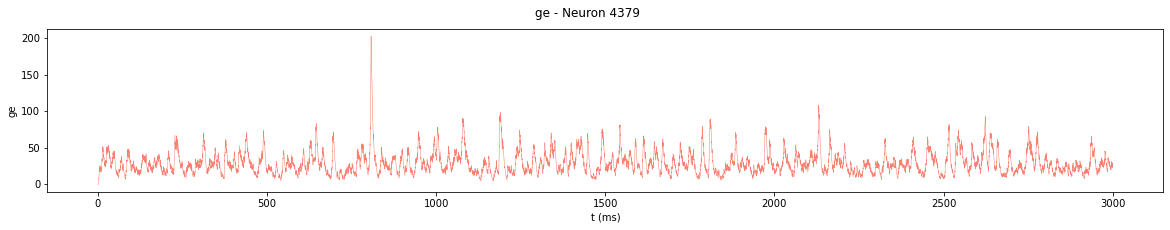

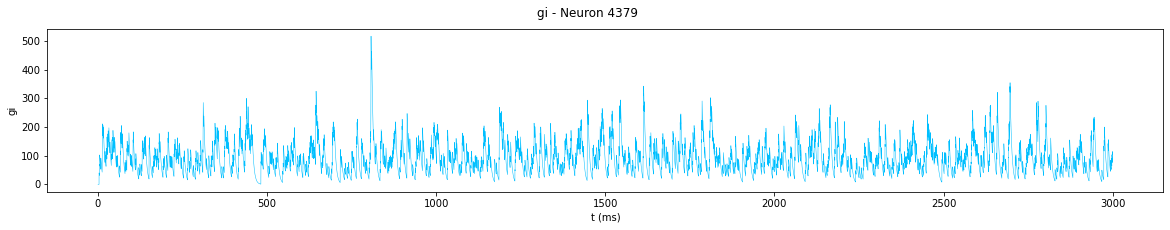

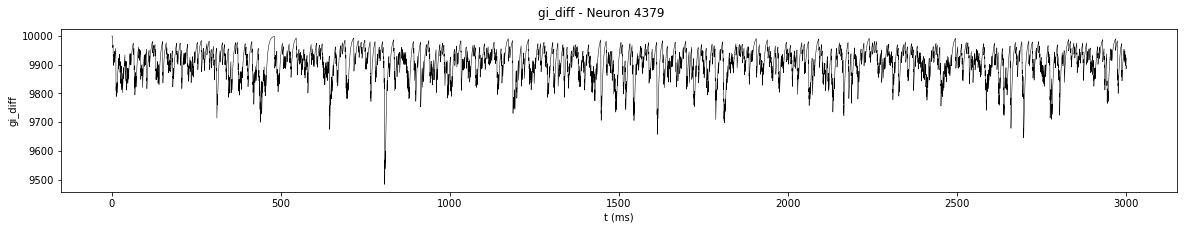

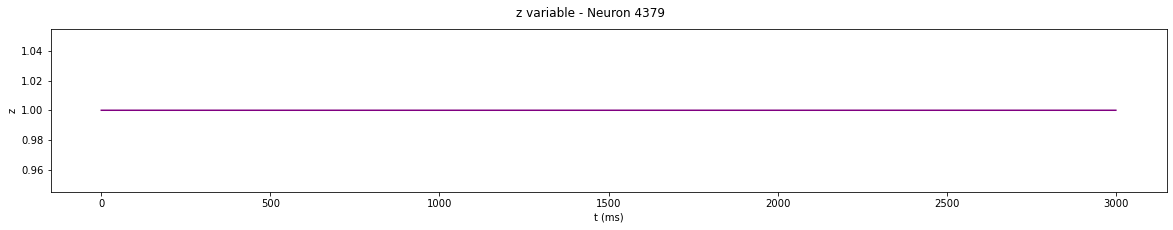

In [5]:
make_plots_inh_exhaust_mech(s_mon, s_mon_p, trace, trace_z, trace_gi_diff, trace_gi, trace_ge, neuron=[Ne[0], Ne[100], Ni[23], Ni[65]])


In [ ]:
for neuron in record_id:
    plt.figure(figsize=[20, 3])
    plot(trace_ge.t / ms, trace_ge[neuron].ge / nS, c='salmon')
    suptitle('Neuron %s' % neuron)
    xlabel('t (ms)')
    ylim([0,400])
    ylabel('ge')
    show()
    
for neuron in record_id:
    plt.figure(figsize=[20, 3])
    plot(trace_gi.t / ms, trace_gi[neuron].gi / nS, c='deepskyblue')
    suptitle('Neuron %s' % neuron)
    xlabel('t (ms)')
    ylim([0,1200])
    ylabel('ge')
    show()

In [ ]:
# reset -f

In [ ]:
#%% calculate correlation coefficients
corr_mtx = np.corrcoef(spike_raster_binned[:int(Ntotal*0.8),:])
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
# not sure why but there are nan values coming up in the corr_values calculation
# remove nans from corr_values

corr_values = x[~np.isnan(x)]
avg_corr = np.mean(corr_values)
print(np.mean(corr_values))

plt.hist(corr_values, bins=100, color='gray')
plt.axvline(x=avg_corr, color='black')
plt.show()

In [ ]:
#%% calculate correlation of the subthreshold membrane potential
trace_array = [trace_ge[x].ge/mvolt for x in record_id]

corr_mtx = np.corrcoef(trace_array)
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
avg_corr = np.mean(x)
print(avg_corr)

In [ ]:
corr_mtx

In [ ]:
plt.hist(spike_counts_Hz, bins=100, color='gray')
plt.axvline(x=avg, color='black')
plt.show()

In [ ]:
plot_inputs(e_monitor=trace_ge, i_monitor=trace_gi, neurons_to_plot=record_id[:3], alpha=0.1)
plot_e_inputs(e_monitor=trace_ge, neurons_to_plot=record_id, alpha=0.1)
plot_i_inputs(i_monitor=trace_gi, neurons_to_plot=record_id, alpha=0.1)